<a href="https://colab.research.google.com/github/JLuceroVasquez/ia-aumentada-prevision-de-atrasos-de-vuelos/blob/main/optimizaci%C3%B3n_aeroportuaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IA aumentada: previsión de atrasos de vuelos**

In [115]:
#Para manipulación de datos
import pandas as pd
import numpy as np

#Para visualización de datos y resultados
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.regressor import prediction_error #Curva del error de la predicción
from yellowbrick.regressor import residuals_plot #Distribución de los residuos de la predicción
from yellowbrick.model_selection import FeatureImportances #Barras de la importancia de las predictoras

#Para transformación de predictoras
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

#Para división de datos en entrenamiento y evaluación, entrenamiento y optimización de modelos ML
from sklearn.model_selection import train_test_split #División de datos en conjunto de entrenamiento y prueba
from sklearn.model_selection import KFold, cross_validate #Entrenamiento y validación cruzada del Modelos ML
from sklearn.model_selection import GridSearchCV #Para optimización de los hiperparámetros de modelos ML

#Modelo ML
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

#Para evaluación de modelos ML
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

#Para exportar e importar en archivos binarios
import pickle

print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de seaborn: {sns.__version__}')

Versión de pandas: 2.2.2
Versión de numpy: 2.0.2
Versión de seaborn: 0.13.2


##**CLASE 1**

###**Importación de datos**

In [116]:
#Leer el encode
'''
import chardet
with open('/content/flights.csv', 'rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']
print(encode)
'''

"\nimport chardet\nwith open('/content/flights.csv', 'rb') as f:\n  diccionario = chardet.detect(f.read())\n  encode = diccionario['encoding']\nprint(encode)\n"

In [117]:
#Importar los datos
url='https://github.com/JLuceroVasquez/ia-aumentada-prevision-de-atrasos-de-vuelos/raw/refs/heads/main/flights.csv'
datos= pd.read_csv(url, encoding='ascii')

#Visualizar  registros al azar
datos.sample(5)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
7851,21,BZ,Boeing 737,schengen,FJB,7.065594,10.065594,158,2011,False,6.016371
27472,27,BZ,Airbus A320,schengen,AUZ,14.376052,16.376052,6,2015,False,16.824453
19520,8,BZ,Airbus A320,schengen,ZQO,15.729617,18.729617,206,2013,False,0.689058
49039,7,MM,Boeing 787,schengen,TZF,8.564949,13.564949,349,2018,False,38.896612
66110,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,27,2022,False,23.997172


In [118]:
#Visualiza la metadata
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       71175 non-null  int64  
 1   airline         71175 non-null  object 
 2   aircraft_type   71175 non-null  object 
 3   schengen        71175 non-null  object 
 4   origin          71175 non-null  object 
 5   arrival_time    71175 non-null  float64
 6   departure_time  71175 non-null  float64
 7   day             71175 non-null  int64  
 8   year            71175 non-null  int64  
 9   is_holiday      71175 non-null  bool   
 10  delay           71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [119]:
#Convertir las columnas categóricas a tipo category
datos = datos.astype({col: 'category' for col in datos.select_dtypes([object, bool]).columns})
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   flight_id       71175 non-null  int64   
 1   airline         71175 non-null  category
 2   aircraft_type   71175 non-null  category
 3   schengen        71175 non-null  category
 4   origin          71175 non-null  category
 5   arrival_time    71175 non-null  float64 
 6   departure_time  71175 non-null  float64 
 7   day             71175 non-null  int64   
 8   year            71175 non-null  int64   
 9   is_holiday      71175 non-null  category
 10  delay           71175 non-null  float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 3.6 MB


###**Análisis de las variables categóricas**

In [120]:
#Reporte de métricas: Variables categóricas
datos.describe(include='category')

,airline,aircraft_type,schengen,origin,is_holiday
count,71175,71175,71175,71175,71175
unique,3,6,2,10,2
top,BZ,Airbus A320,schengen,TZF,False
freq,47598,30778,42569,14162,67275


In [121]:
#Insumos
y_name = 'delay'
X_names = datos.select_dtypes('category').columns

'''
En el futuro, el comportamiento por defecto del parámetro observed cuando se
agrupan datos (groupby) que tienen columnas categóricas (category) será True.
Por eso, a fin de evitar mensajes de avertencia, se establece como True en la
función groupby. Esto incluirá solo las categorías presentes en los datos }
agrupados, omitiendo las que no aparecen (si es que se configuraron adicionales
al crear el dataframe).

Por ejemplo:
df = pd.DataFrame({
    'A': pd.Categorical(['x', 'y'], categories=['x', 'y', 'z']),
    'B': [1, 2]
})
'''
df_delay = []
for predictor in X_names:
  df = datos.groupby(predictor, observed=True)[y_name].mean().sort_values(ascending=False).reset_index()
  df_delay.append(df)

lista_orden = []
for predictor in X_names:
  lista = datos[predictor].value_counts().index.tolist()
  lista_orden.append(lista)

**Funciones personalizadas para graficar con Seaborn en subplots**

Ambas funciones reciben un eje específico de Matplotlib (ax) para que el gráfico
se dibuje dentro de una figura con múltiples subplots, lo cual es útil para
visualizaciones comparativas.

*Parámetros comunes:*

* x_name: nombre de la columna que irá en el eje X.

* y_name: (solo en barplot_delay) nombre de la columna que irá en el eje Y.

* df: DataFrame que contiene los datos.

* bar_order: (solo en countplot_vuelos) lista con los nombres de las categorías en el orden que irán en el eje X.

* rotation_xticks: ángulo de rotación para las etiquetas del eje X.

* ax: objeto Axes de Matplotlib donde se dibujará el gráfico.

*barplot_delay():*

    Crea un gráfico de barras (sns.barplot) que muestra el valor promedio de y_name
    según cada categoría de x_name. Es ideal para comparar promedios agrupados.

*countplot_vuelos():*

    Crea un gráfico de conteo (sns.countplot) que muestra cuántas veces aparece
    cada categoría de x_name en el DataFrame. Permite ordenar las barras si se
    pasa una lista en bar_order.

*Ambas funciones:*

* Usan ax.set_title(), ax.set_xlabel() y ax.set_ylabel() para personalizar textos.

* Usan ax.set_xticklabels(..., rotation=...) para rotar etiquetas y mejorar legibilidad.

* Devuelven el objeto Axes, lo que permite encadenar personalizaciones si se desea.

In [122]:
#Herramientas
def barplot_delay(x_name, y_name, df, bar_order=None, rotation_xticks: float = 0, ax=None):
    ax = sns.barplot(x=x_name, y=y_name, data=df, order=bar_order, ax=ax)
    ax.set_title(f'{y_name} según {x_name}')
    ax.set_xlabel(x_name)
    ax.set_ylabel('Atraso promedio en minutos')
    ax.tick_params(axis='x', rotation=rotation_xticks)
    return ax

def countplot_vuelos(x_name, df, bar_order=None, rotation_xticks: float = 0, ax=None):
    ax = sns.countplot(data=df, x=x_name, order=bar_order, ax=ax)
    ax.set_title(f'Cantidad de vuelos según {x_name}')
    ax.set_xlabel(x_name)
    ax.set_ylabel('Cantidad de vuelos')
    ax.tick_params(axis='x', rotation=rotation_xticks)
    return ax

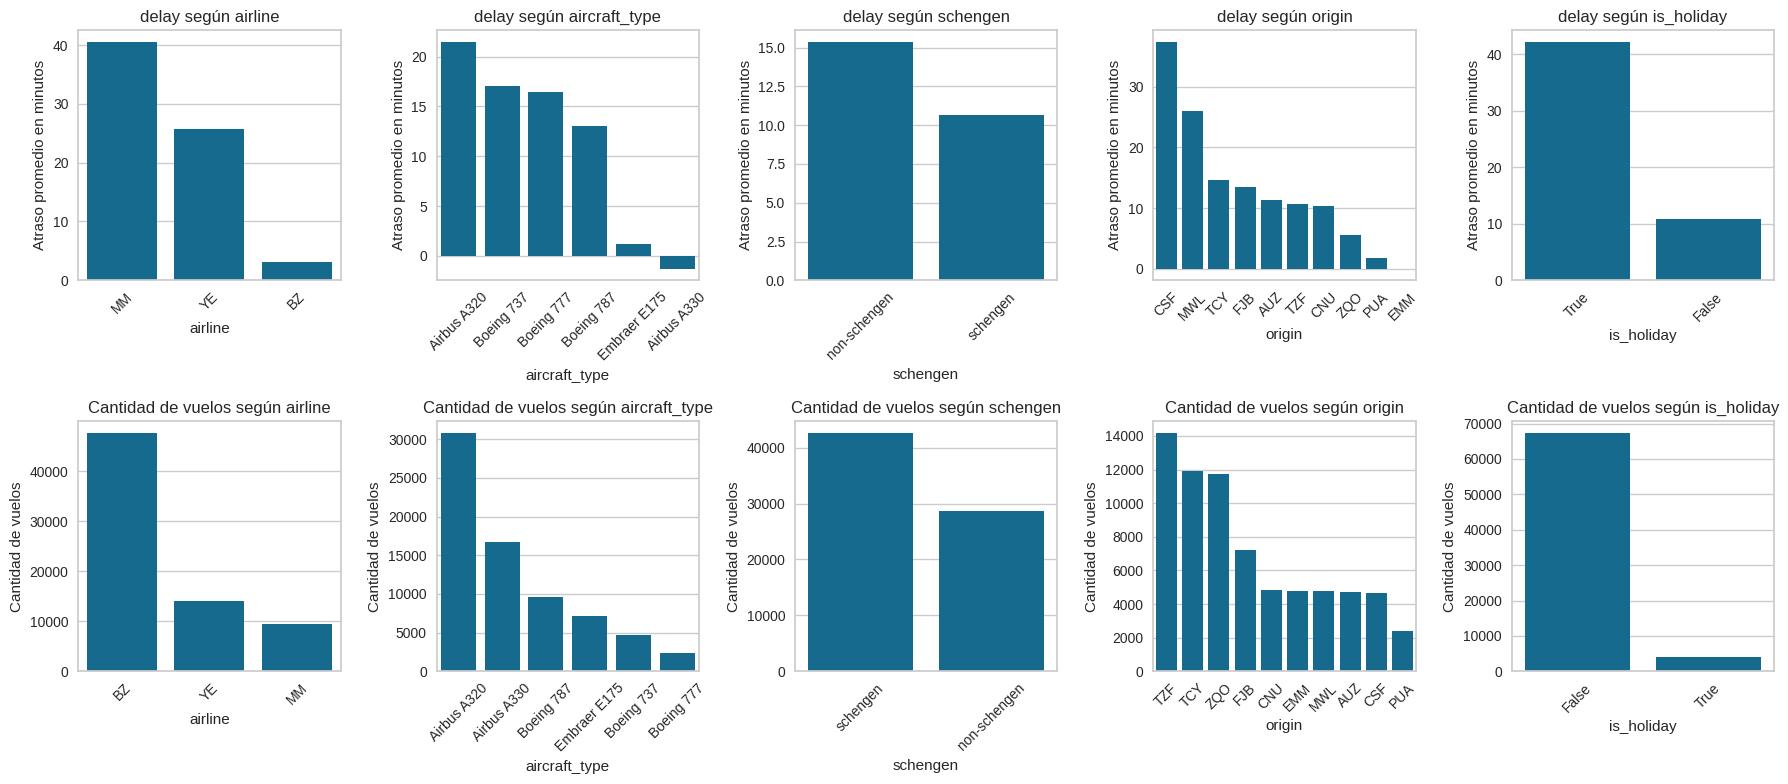

In [123]:
#Visualización
# Crear figura y ejes
fig, axs = plt.subplots(2, 5, figsize=(18, 8))

# Primera fila -> barplot
'''
axs.flat no es un objeto que soporte slicing directo (axs.flat[:5]), porque es
un iterador de NumPy, no una lista. Por eso se convierte a lista.
'''
for i, ax in enumerate(list(axs.flat)[:5]): # Solo primeros 5 (primera fila)
  bar_order = df_delay[i][X_names[i]].unique().tolist() #Generamos una lista con el orden de las categorías del eje X
  barplot_delay(X_names[i], y_name, df_delay[i], bar_order=bar_order, rotation_xticks=45, ax=ax)

# Segunda fila -> countplot
for i, ax in enumerate(list(axs.flat)[5:]): # Los últimos 5 (segunda fila)
  countplot_vuelos(X_names[i], datos, bar_order=lista_orden[i], rotation_xticks=45, ax=ax)

plt.tight_layout()
plt.show()

###**Análisis de las variable numéricas**

In [124]:
#Reporte de métricas: Variables numéricas
datos.describe()

,flight_id,arrival_time,departure_time,day,year,delay
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


**Variables excluidas del análisis**

Las variables numéricas del dataframe datos son las siguientes:

    'flight_id', 'arrival_time', 'departure_time', 'day', 'year', 'delay'

Sin embargo, no se analizó las variables `flight_id` y `year` debido a que no contribuyen información relevante para la predicción de retrasos de vuelos.

* `flight_id:` Aunque esté codificada como numérica, en realidad es una identificación única de cada vuelo.
* `year:` Es una variable histórica. Si el modelo será usado para predecir retrasos de vuelos futuros, no tendrá sentido incluir un valor de año que esos datos no contengan. Además, en este caso, el efecto estacional del año se capta indirectamente a través de otras variables como `'day'`.

Excluir siempre identificadores y campos no disponibles en datos futuros es una buena práctica para evitar [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage).

**Cálculo del ancho de los intervalos**

Para los gráficos de histograma, se calculó el ancho de los intervalos usando la [regla Diaconis](https://www.google.com/url?q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FFreedman%25E2%2580%2593Diaconis_rule).

In [125]:
#Insumos
col_names = ['arrival_time', 'departure_time', 'day', 'delay']

#Lista de medianas
medianas = {}
for col in col_names:
  medianas[col] = datos[col].median()

#Lista de medias
medias = {}
for col in col_names:
  medias[col] = datos[col].mean()

#Función para el cálculo de ancho de intervalo usando
def anchointervalo(df, col):
  q1, q3 = np.percentile(a=df[col], q=[25,75])
  iqr = q3 - q1
  ancho = 2 * iqr / (len(df) ** (1/3))
  return ancho
#Lista de ancho de intervalo
anchos = {}
for col in col_names:
  anchos[col] = anchointervalo(datos, col)

**Funciones para los gráficos**

La función **boxplot_numericas** recibe el nombre de una columna numérica, un DataFrame y opcionalmente un objeto de ejes de Matplotlib. Utiliza Seaborn para crear un diagrama de caja de la columna especificada sobre el eje indicado. Agrega una línea horizontal roja discontinua para marcar la media de la columna, extraída del diccionario global medias, y añade una leyenda para identificarla. Devuelve el objeto de ejes para permitir su integración en figuras con múltiples gráficos.

La función **histplot_numericas** recibe parámetros similares, pero genera un histograma con densidad (kde) utilizando Seaborn. Configura el ancho de las barras a partir del valor correspondiente en el diccionario global anchos. El histograma se complementa con una línea roja discontinua para la media y una línea amarilla discontinua para la mediana, tomadas de los diccionarios globales medias y medianas, respectivamente. También se desactiva la cuadrícula, se establecen títulos y etiquetas, y se añade una leyenda para identificar las referencias. Al igual que la anterior, devuelve el objeto de ejes para su posterior manipulación o visualización en conjuntos de gráficos.

In [126]:
#Herramientas
def boxplot_numericas(col, df, ax=None):
  ax = sns.boxplot(data=df, y=col, ax=ax)
  ax.set_title(f'Boxplot de {col}')
  ax.axhline(y=medias[col], color='r', linestyle='--', label='Media')
  ax.legend()
  return ax

def histplot_numericas(col, df, ax=None):
  ax = sns.histplot(data=df, x=col, ax=ax, kde=True, binwidth=anchos[col])
  ax.set_ylabel('Número de vuelos')
  ax.grid(False)
  ax.set_title(f'Histograma de {col}')
  ax.axvline(x=medias[col], color='r', linestyle='--', label='Media')
  ax.axvline(x=medianas[col], color='y', linestyle='--', label='Mediana')
  ax.legend()
  return ax

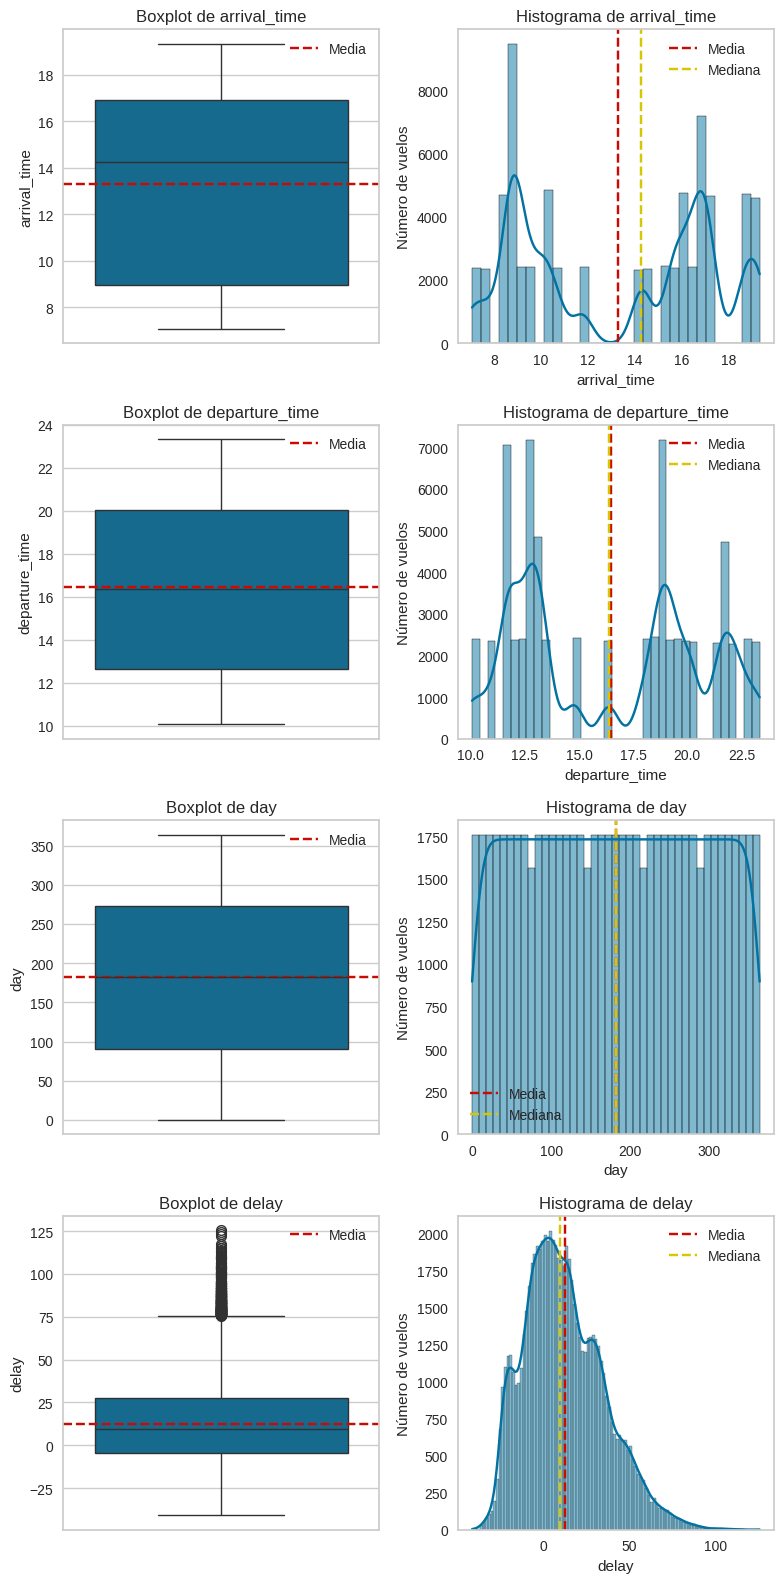

In [127]:
#Visualización
# Crear figura y ejes
fig, axs = plt.subplots(4, 2, figsize=(8, 16))

# Primera columna -> boxplot | Segunda fila -> histplot
'''
Se accede al nombre de la columna dividiendo el n° de eje entre 2 y redondeando
hacia abajo ¿Por qué? Son 8 ejes, y 4 variables numéricas. Por tanto:
Ejes                | Columna
-------------------------------------
(0, 1) // 2 = 0     | arrival_time
(2, 3) // 2 = 1     | departure_time
(4, 5) // 2 = 2     | day
(6, 7) // 2 = 3     | delay
'''
for i, ax in enumerate(axs.flat):
  if i % 2 == 0:
    boxplot_numericas(col_names[i//2], datos, ax=ax)
  else:
    histplot_numericas(col_names[i//2], datos, ax=ax)

plt.tight_layout()
plt.show()

##**CLASE 2**
En esta clase se realizó el *feature engineering*. Esta técnica consiste en **mejora el rendimiento del modelo** eligiendo y transformando las features (variables predictoras). Unas features bien diseñadas capturan información relevante y eliminan ruido en los datos.

Asimismo, en conjuntos de datos con muchas features, la dimensionalidad de los datos puede convertirse en un problema. El feature engineering puede ayudar a **reducir la cantidad de features**, manteniendo solo aquellas que son realmente informativas para el modelo.

Entre las técnicas de feature engineering encontramos:
* Creación de nuevas features a partir de existentes.
* Transformación de features para escalar datos.
* Selección de features más importantes.

###**Creación de features**

In [128]:
#Concatenamos los textos de 'day' y 'year'
#Se suma 1 al n° de día porque el valor mínimo es 0 y el valor máximo 364.
datos['date'] = datos['year'].astype(str) + '-' + (datos['day']+1).astype(str)
#Convertimos los textos de 'date' en datos tipo datetime
datos['date'] = pd.to_datetime(arg=datos['date'], format='%Y-%j')
datos.sample(2)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date
23225,16,MM,Airbus A320,non-schengen,CSF,17.041281,20.041281,88,2014,False,56.241338,2014-03-30
44725,21,BZ,Boeing 737,schengen,FJB,7.065594,10.065594,61,2018,False,28.514899,2018-03-03


In [129]:
#Generamos la columna 'is_weekend' para indicar si la fecha coincide con un sábado o domingo
datos['is_weekend'] = datos['date'].dt.weekday.isin([5,6]) #Lunes tiene el indice 0.
#Geneneramos la columna 'day_name' para indicar el nombre del día según la fecha
datos['day_name'] = datos['date'].dt.day_name()
datos.sample(5)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,day_name
41434,4,BZ,Airbus A330,schengen,TCY,11.781391,14.781391,207,2017,False,-18.686659,2017-07-27,False,Thursday
43154,22,YE,Airbus A320,non-schengen,MWL,8.794147,11.794147,321,2017,False,40.458405,2017-11-18,True,Saturday
61573,30,BZ,Embraer E175,schengen,PUA,8.923441,12.923441,89,2021,False,-13.239755,2021-03-31,False,Wednesday
10969,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,1,2012,False,-25.942664,2012-01-02,False,Monday
55382,17,BZ,Airbus A330,non-schengen,CNU,16.718722,21.718722,42,2020,False,22.869214,2020-02-12,False,Wednesday


In [130]:
#Convertir las columnas categóricas creadas a tipo category
datos = datos.astype({col: 'category' for col in datos.select_dtypes([object, bool]).columns})
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   flight_id       71175 non-null  int64         
 1   airline         71175 non-null  category      
 2   aircraft_type   71175 non-null  category      
 3   schengen        71175 non-null  category      
 4   origin          71175 non-null  category      
 5   arrival_time    71175 non-null  float64       
 6   departure_time  71175 non-null  float64       
 7   day             71175 non-null  int64         
 8   year            71175 non-null  int64         
 9   is_holiday      71175 non-null  category      
 10  delay           71175 non-null  float64       
 11  date            71175 non-null  datetime64[ns]
 12  is_weekend      71175 non-null  category      
 13  day_name        71175 non-null  category      
dtypes: category(7), datetime64[ns](1), float64(3), int64(3

###**Transformación de features**
Se transformaron las columnas con categorías binarias por separado de las otras columnas categóricas para tener control sobre que valor es asignado a cada categoría.

In [131]:
#Transformación de columnas categóricas binarias, renombrando como números enteros
datos['schengen'] = datos['schengen'].cat.rename_categories({'non-schengen': 0, 'schengen': 1})
datos['is_holiday'] = datos['is_holiday'].cat.rename_categories({False: 0, True: 1})
datos['is_weekend'] = datos['is_weekend'].cat.rename_categories({False: 0, True: 1})

#Se cambia el tipo de datos a entero
datos = datos.astype({col: np.int64 for col in ['schengen','is_holiday','is_weekend']})
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   flight_id       71175 non-null  int64         
 1   airline         71175 non-null  category      
 2   aircraft_type   71175 non-null  category      
 3   schengen        71175 non-null  int64         
 4   origin          71175 non-null  category      
 5   arrival_time    71175 non-null  float64       
 6   departure_time  71175 non-null  float64       
 7   day             71175 non-null  int64         
 8   year            71175 non-null  int64         
 9   is_holiday      71175 non-null  int64         
 10  delay           71175 non-null  float64       
 11  date            71175 non-null  datetime64[ns]
 12  is_weekend      71175 non-null  int64         
 13  day_name        71175 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(3), int64(6

In [133]:
#Lista de nombre de las columnas tipo category
categoricas = [col for col in datos.select_dtypes('category').columns]
#Configuración del transformador de columnas
one_hot = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),#El argumento handle_unknown='ignore' significa que el OneHotEncoder ignorará cualquier categoría desconocida que pueda aparecer durante la transformación.
                                   categoricas),
                                  remainder='passthrough',#Las columnas no nombradas en el transformador, se mantienen.
                                  sparse_threshold=0, #Proporción mínima de datos diferente de ceros que, de no superarse, genera una matriz sparse para optimizar la memoria y eficiencia computacional.
                                  force_int_remainder_cols=False) #Establecer en Falso mantiene los nombres de las columnas transformadas, en lugar de convertirlas en enteros.

#Transformación del conjunto de datos
datos_transformados = one_hot.fit_transform(datos)

#Creación del dataframe con las columnas transformadas
datos_transformados = pd.DataFrame(datos_transformados, columns=one_hot.get_feature_names_out())
datos_transformados.head()


,onehotencoder__airline_BZ,onehotencoder__airline_MM,onehotencoder__airline_YE,onehotencoder__aircraft_type_Airbus A320,onehotencoder__aircraft_type_Airbus A330,onehotencoder__aircraft_type_Boeing 737,onehotencoder__aircraft_type_Boeing 777,onehotencoder__aircraft_type_Boeing 787,onehotencoder__aircraft_type_Embraer E175,onehotencoder__origin_AUZ,...,remainder__flight_id,remainder__schengen,remainder__arrival_time,remainder__departure_time,remainder__day,remainder__year,remainder__is_holiday,remainder__delay,remainder__date,remainder__is_weekend
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,0,8.885071,10.885071,0,2010,0,70.205981,2010-01-01,0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,0,8.939996,11.939996,0,2010,0,38.484609,2010-01-01,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3,1,18.635384,22.635384,0,2010,0,2.388305,2010-01-01,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,28,0,15.967963,17.967963,0,2010,0,19.138491,2010-01-01,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,15,0,16.571894,19.571894,0,2010,0,15.016271,2010-01-01,0


###**Selección de features**
* Se eliminaron las columnas: `flight_id`, `day`, `year`, `date`. Debido a que no aportan información relevante para la predicción de retraso de vuelos.
* Se creó una matriz de correlación entre las variables numéricas, para identificar aquellas con un comportamiento similar. Se identifico que `arrival_time` y `departure_time` tienen una alta correlación, con lo cual se elimino `departure_time` para evitar mantener información redundante que perjudique la exactitud del modelo.

In [134]:
datos_transformados.columns

Index(['onehotencoder__airline_BZ', 'onehotencoder__airline_MM',
       'onehotencoder__airline_YE', 'onehotencoder__aircraft_type_Airbus A320',
       'onehotencoder__aircraft_type_Airbus A330',
       'onehotencoder__aircraft_type_Boeing 737',
       'onehotencoder__aircraft_type_Boeing 777',
       'onehotencoder__aircraft_type_Boeing 787',
       'onehotencoder__aircraft_type_Embraer E175',
       'onehotencoder__origin_AUZ', 'onehotencoder__origin_CNU',
       'onehotencoder__origin_CSF', 'onehotencoder__origin_EMM',
       'onehotencoder__origin_FJB', 'onehotencoder__origin_MWL',
       'onehotencoder__origin_PUA', 'onehotencoder__origin_TCY',
       'onehotencoder__origin_TZF', 'onehotencoder__origin_ZQO',
       'onehotencoder__day_name_Friday', 'onehotencoder__day_name_Monday',
       'onehotencoder__day_name_Saturday', 'onehotencoder__day_name_Sunday',
       'onehotencoder__day_name_Thursday', 'onehotencoder__day_name_Tuesday',
       'onehotencoder__day_name_Wednesday', 're

In [135]:
#Se eliminan features irrelevante
datos_transformados.drop(columns=['remainder__flight_id', 'remainder__day', 'remainder__year', 'remainder__date'], inplace=True)

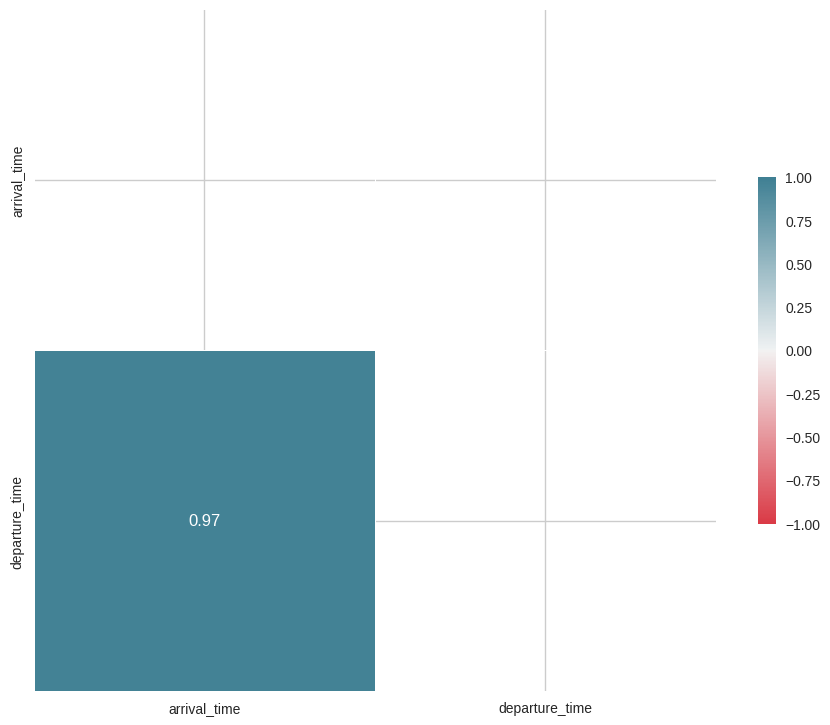

In [136]:
#Se crea una matriz de correlación entre las variables numéricas para eliminar features redundantes
numericas = ['arrival_time','departure_time']
corr=datos[numericas].corr()

# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Generar el mapa de calor (heatmap)
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Mostrar el mapa de calor (heatmap)
plt.show()

In [137]:
#Se eliminan features redundantes
datos_transformados.drop(columns=['remainder__departure_time'], inplace=True)

#Se visualiza el dataframe tras las técnicas de feature engineering
datos_transformados.sample(10)

,onehotencoder__airline_BZ,onehotencoder__airline_MM,onehotencoder__airline_YE,onehotencoder__aircraft_type_Airbus A320,onehotencoder__aircraft_type_Airbus A330,onehotencoder__aircraft_type_Boeing 737,onehotencoder__aircraft_type_Boeing 777,onehotencoder__aircraft_type_Boeing 787,onehotencoder__aircraft_type_Embraer E175,onehotencoder__origin_AUZ,...,onehotencoder__day_name_Saturday,onehotencoder__day_name_Sunday,onehotencoder__day_name_Thursday,onehotencoder__day_name_Tuesday,onehotencoder__day_name_Wednesday,remainder__schengen,remainder__arrival_time,remainder__is_holiday,remainder__delay,remainder__is_weekend
48917,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,15.496519,0,9.956027,1
6017,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,8.591208,0,4.337874,1
46151,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,8.591208,0,-4.804686,0
20205,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1,14.258911,0,35.030007,0
57013,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,19.196804,1,31.281496,1
32367,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,15.729617,0,-4.016926,1
18398,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,10.177197,0,8.913756,1
69426,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,17.041281,0,41.120337,0
1708,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,15.729617,0,0.572993,1
30418,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1,14.258911,0,10.040716,0


##**CLASE 3**

https://scikit-learn.org/stable/

In [138]:
#Función para imprimir métricas de evaluación del modelo ML
def evaluarRegresion(y_true, y_pred):
  rmse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  evaluacion = {'RMSE':round(rmse**(1/2),4),
                'MAE':round(mae,4),
                'R2':round(r2,4)}
  return evaluacion

In [139]:
#División de los datos en predictoras y variable de respuesta
X = datos_transformados.drop(columns='remainder__delay')
y = datos_transformados['remainder__delay']

In [140]:
#División de los datos en entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###**Entrenando con Dummyregressor (baseline)**
Se configuró, entrenó y evaluó las distintas estrategias del modelo [DummyRegressor de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html), concluyendo que la mejor estrategia es la que siempre predice el valor del cuantil 25 (cuartil 1) aunque también es la que más error produce.

In [141]:
#Ciclo for para probar distintas estrategias del DummyRegressor
estrategias = ['mean', 'median', ('quantile',0.25), ('constant',0.1)]

for estrategia in estrategias:
  if isinstance(estrategia, tuple):
    estrategia, valor = estrategia
    if estrategia == 'quantile':
      modelo = DummyRegressor(strategy=estrategia, quantile=valor)
    if estrategia == 'constant':
      modelo = DummyRegressor(strategy=estrategia, constant=valor)
  else:
    modelo = DummyRegressor(strategy=estrategia)

  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)
  evaluacion = evaluarRegresion(y_test, y_pred)

  print(f'Evaluación de la estrategia {estrategia}:')
  print('--'*20)
  for metrica, valor in evaluacion.items():
    print(f'{metrica}: {valor}')
    print('\n')

Evaluación de la estrategia mean:
----------------------------------------
RMSE: 23.1612


MAE: 18.5646


R2: -0.0


Evaluación de la estrategia median:
----------------------------------------
RMSE: 23.3446


MAE: 18.4452


R2: -0.0159


Evaluación de la estrategia quantile:
----------------------------------------
RMSE: 28.7554


MAE: 22.0248


R2: -0.5414


Evaluación de la estrategia constant:
----------------------------------------
RMSE: 26.3248


MAE: 20.1058


R2: -0.2919




###**Entrenando con bosques aleatorios**

In [142]:
#Configuración y entrenamiedo del modelo RandomForestRegressor
modelo_rf = RandomForestRegressor(max_depth=5, random_state=42)
modelo_rf.fit(X_train, y_train)

#Predicción de y para X_test (regresores de prueba)
y_pred = modelo_rf.predict(X_test)

#Evaluación del modelo a partir de métricas
evaluacion = evaluarRegresion(y_test, y_pred)
print(f'Evaluación del modelo RandomForest:')
print('--'*20)
for metrica, valor in evaluacion.items():
  print(f'{metrica}: {valor}')
  print('\n')

Evaluación del modelo RandomForest:
----------------------------------------
RMSE: 13.7479


MAE: 11.0262


R2: 0.6477




/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


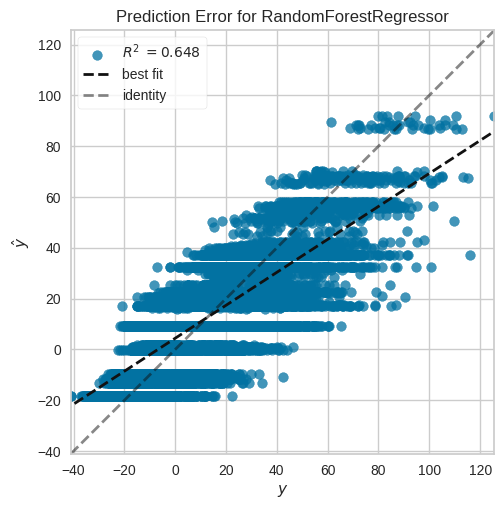

In [100]:
#Gráfico del error de la predicción
'''
Cuánto más cerca esté la recta 'best_fit' de 'identity', más exacto es el modelo
'''
visualizacion = prediction_error(modelo_rf, X_train, y_train, X_test, y_test);

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


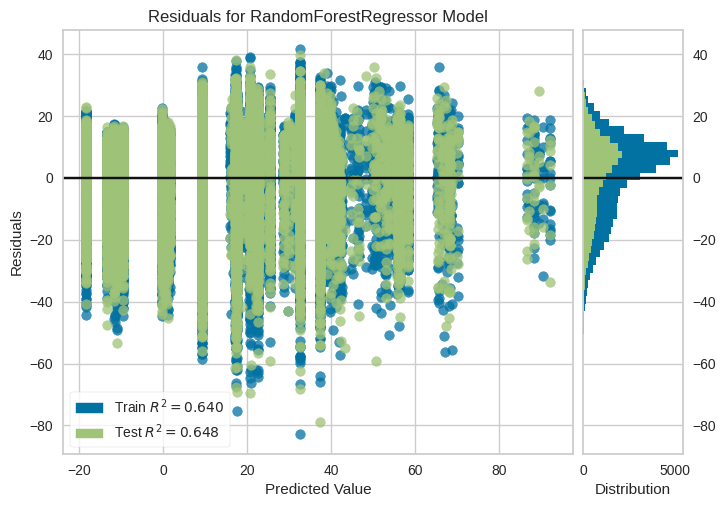

In [101]:
#Gráfico de la distribución de los errores
'''
Cuán más cerca estén los errores de la línea '0', más exacto es el modelo.
Cuanto más parecida la distribución de errores de los conjuntos de entrenamiento
y de prueba, significa que le modelo predijo con exactitud parecida en ambos
conjuntos.
'''
vizualizacion = residuals_plot(modelo_rf, X_train, y_train, X_test, y_test);

###**Validación cruzada de los bosques aleatorios**

In [143]:
#Diccionario de métricas
'''
De acuerdo a la documentación, los objeto tipo scorer que pueden ser designados
usando el parámetro "scoring", deben respetar la convención de que "los valores
más altos, son mejores que los valores más bajos". Por eso, los valores que
son mejores cuanto más bajo son como "el error cuadrático medio" son negados
(multiplicados por -1) para que respeten la convención y se encuentran
disponibles con el nombre, por ejemplo, de 'neg_mean_squared_error'.
'''
'''
De acuerdo con la documentación, en la validación cruzada, se puede especificar
qué metrica(s) se devolverá(n) como resultado. Si se desea detallar muchas
métricas, se puede emplear un diccionario. Donde las claves son el nombre de la
métrica (que puede personalizarse), y los valores pueden ser funciones tipo
scorer (es decir que construidas con 'make_scorer()') o el nombre predefinido de
la métrica en Sklearn pasado como cadena de texto.
'''
metricas = {'Neg_RMSE': 'neg_root_mean_squared_error',
            'Neg_MAE': 'neg_mean_absolute_error',
            'R2': 'r2'}

In [144]:
#Validación cruzada usando el método KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Resultado de la validación cruzada a partir de los datos de entrenamiento y el modelo RandomFores
cv_resultado = cross_validate(modelo_rf, X_train, y_train, cv=cv, scoring=metricas)

#Impresión de resultados
'''
Una baja variación en las métricas (desviación estándar), indica que el modelo
mantuvo un mismo desempeño en los 5 conjuntos de validación.
'''
for metrica in metricas.keys():
  scores = cv_resultado[f'test_{metrica}']
  media = scores.mean()
  desviacion = scores.std()

  print(f' Puntajes de la métrica {metrica}:\n',
        f'{["{:.3f}".format(valor) for valor in scores]}\n',
        f'Media:{media:.3f} y desviación estándar: {desviacion:.3f}')
  print('\n')

 Puntajes de la métrica Neg_RMSE:
 ['-13.770', '-13.869', '-13.968', '-13.853', '-13.990']
 Media:-13.890 y desviación estándar: 0.080


 Puntajes de la métrica Neg_MAE:
 ['-11.033', '-11.135', '-11.209', '-11.145', '-11.258']
 Media:-11.156 y desviación estándar: 0.076


 Puntajes de la métrica R2:
 ['0.646', '0.637', '0.635', '0.641', '0.634']
 Media:0.639 y desviación estándar: 0.004




##**CLASE 4**

### **Feature engineering II: Selección de características**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


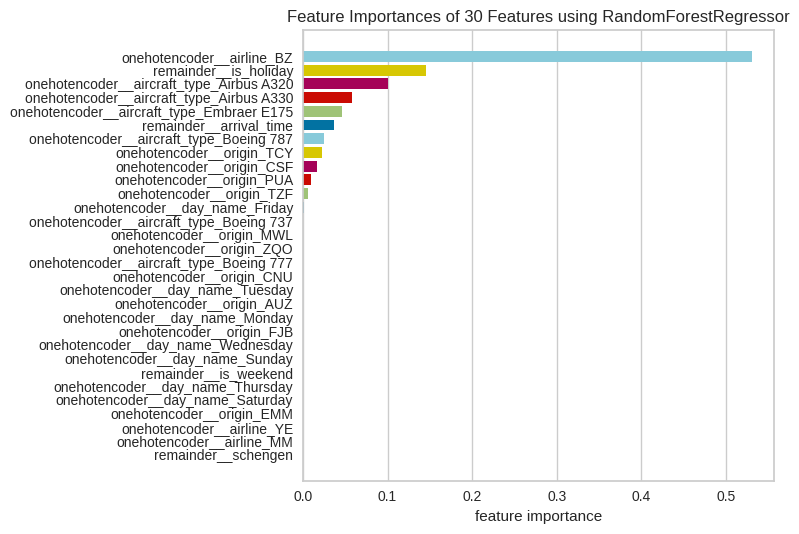

In [145]:
modelo_rf

#Figura creada con YellowBrick de la importancia de variables predictoras
'''
Se establece como falso el parámetro "relative", con lo cual, el gráfico no
mostrará la importancia de las variables predictoras respecto a la variable de
mayor importancia. Sino que mostrará una descripción numérica sin procesar de
la importancia de las variables predictoras.
'''
vizualizacion = FeatureImportances(modelo_rf, relative=False)
vizualizacion.fit(X_train, y_train)
vizualizacion.show();

In [146]:
#Puntajes de importancia de cada variable predictora (en el orden que aparece en X_train)
importances = modelo_rf.feature_importances_

#Creación de un dataframe ordenado con el nombre e importancia de cada variable predictora como columnas
df_importancias = pd.DataFrame(data={'Predictora': X_train.columns,
                                     'Importancia': importances})
df_importancias.sort_values(by='Importancia', ascending=False, inplace=True)
df_importancias.head(13)

,Predictora,Importancia
0,onehotencoder__airline_BZ,0.530320
28,remainder__is_holiday,0.145896
3,onehotencoder__aircraft_type_Airbus A320,0.100738
4,onehotencoder__aircraft_type_Airbus A330,0.057618
8,onehotencoder__aircraft_type_Embraer E175,0.045908
27,remainder__arrival_time,0.036357
7,onehotencoder__aircraft_type_Boeing 787,0.025079
16,onehotencoder__origin_TCY,0.022272
11,onehotencoder__origin_CSF,0.016371
15,onehotencoder__origin_PUA,0.009873


Iteración para evaluar el modelo RandomForest considerando diferentes cantidades de variables predictoras

In [147]:
#Dataframe para alamcenar los resultados por cada variación en la cantidad de predictoras
df_resultados = pd.DataFrame(index=['RMSE','MAE','R2'])

#Iteración del 1 al 30, saltando de 5 en 5
ct_features = [i if i != 0 else 1 for i in range(0,35,5)]

for cantidad in ct_features:
  #Selección de nombres de features según cantidad
  features_selected = df_importancias['Predictora'][:cantidad].values
  #Filtrado del conjunto de entrenamiento y prueba con base a los nombres de los features seleccionados
  X_train_selected = X_train[features_selected]
  X_test_selected = X_test[features_selected]
  #Entrenamiento del modelo
  modelo_rf.fit(X_train_selected, y_train)
  #Predicción de y para X_test (regresores de prueba)
  y_pred = modelo_rf.predict(X_test_selected)
  #Evaluacion del modelo
  evaluacion = evaluarRegresion(y_test, y_pred)
  #Almacenamiento de resultados
  df_resultados[cantidad] = evaluacion.values()

df_resultados

,1,5,10,15,20,25,30
RMSE,18.8331,15.1564,13.7587,13.7497,13.7474,13.7480,13.7479
MAE,14.9620,12.0605,11.0422,11.0285,11.0258,11.0262,11.0262
R2,0.3388,0.5718,0.6471,0.6476,0.6477,0.6477,0.6477


In [148]:
#Dataframe para alamcenar los resultados por cada variación en la cantidad de predictoras
df_resultados = pd.DataFrame(index=['RMSE','MAE','R2'])

#Iteración del 10 al 15
ct_features = range(10,16)

for cantidad in ct_features:
  #Selección de nombres de features según cantidad
  features_selected = df_importancias['Predictora'][:cantidad].values
  #Filtrado del conjunto de entrenamiento y prueba con base a los nombres de los features seleccionados
  X_train_selected = X_train[features_selected]
  X_test_selected = X_test[features_selected]
  #Entrenamiento del modelo
  modelo_rf.fit(X_train_selected, y_train)
  #Predicción de y para X_test (regresores de prueba)
  y_pred = modelo_rf.predict(X_test_selected)
  #Evaluacion del modelo
  evaluacion = evaluarRegresion(y_test, y_pred)
  #Almacenamiento de resultados
  df_resultados[cantidad] = evaluacion.values()

df_resultados

,10,11,12,13,14,15
RMSE,13.7587,13.7564,13.7526,13.7496,13.7497,13.7497
MAE,11.0422,11.0425,11.0312,11.0282,11.0285,11.0285
R2,0.6471,0.6472,0.6474,0.6476,0.6476,0.6476


In [108]:
#Selección de las 13 características más importantes
features_selected = df_importancias['Predictora'][:13].values
X_selected = X[features_selected]

#División del df con features seleccionados en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

### **Optimización de hiperparámetros de modelo**

In [109]:
#Diccionario con lista de valores para cuatro hiperparámetros del modelo RandomForestRegressor
param_grid = {
              'max_depth': [5, 10, 15],
              'min_samples_leaf': [1, 2, 3],
              'min_samples_split': [2, 4, 6],
              'n_estimators': [100, 150, 200]
              }

In [69]:
#Configuración de la validación cruzada con KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Configuración de la validación cruzada que probará diferentes combinaciones de hiperparámetros en el modelo RandomForestRegressor
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='r2',
                           n_jobs=-1,
                           cv=cv)

#Entrenamiento de 81 modelos generados con todas las combinaciones de hiperparámetros
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='r2')

In [71]:
#Mejor combinación de parámetros
grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [111]:
#Predicción de y a partide X_train con el modelo RandomForestRegressor que tiene la mejor combinación de parámetros
'''
De acuerdo con la documentación, GridSearchCV aplica métodos de su estimador
(modelo), ej. predict, considerando la mejor combinación de parámetros
de entre todas las opciones disponibles en el diccionario de hiperparámetros.
'''
y_pred_grid = grid_search.predict(X_test)

#Cálculo de las métricas de evaluación del modelo con hiperparámetros optimizados
evaluacion_grid = evaluarRegresion(y_test, y_pred_grid)

#Añadimos la evaluación al DataFrame df_resultados
df_resultados['Grid model'] = evaluacion_grid.values()
df_resultados

,10,11,12,13,14,15,Grid model
RMSE,13.7587,13.7564,13.7526,13.7496,13.7497,13.7497,13.2525
MAE,11.0422,11.0425,11.0312,11.0282,11.0285,11.0285,10.6499
R2,0.6471,0.6472,0.6474,0.6476,0.6476,0.6476,0.6726


### **Exportación del modelo**

In [112]:
#Exportación del modelo con Pickel
try:
  with open('modelo_champion.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_,file)
  print('Modelo exportado con exito!')

except Exception as e:
  print(f'Error durante la exportación del modelo: {e}')

Modelo exportado con exito!


### **Importación del modelo y predicción**

In [113]:
#Importación del modelo con Pickel
try:
  with open('/content/modelo_champion.pkl', 'rb') as file:
    modelo_champion = pickle.load(file)
  print('Modelo importado con exito!')

except Exception as e:
  print(f'Error durante la importación del modelo: {e}')

Modelo importado con exito!


In [151]:
#Creación del DataFrame con nuevos datos
diccionario = {
              'onehotencoder__airline_BZ': 0,
              'remainder__is_holiday': 0,
              'onehotencoder__aircraft_type_Airbus A320': 1,
              'onehotencoder__aircraft_type_Airbus A330': 0,
              'onehotencoder__aircraft_type_Embraer E175': 0,
              'remainder__arrival_time': 10.8941,
              'onehotencoder__aircraft_type_Boeing 787': 0,
              'onehotencoder__origin_TCY': 0,
              'onehotencoder__origin_CSF': 0,
              'onehotencoder__origin_PUA': 0,
              'onehotencoder__origin_TZF': 0,
              'onehotencoder__day_name_Friday': 0,
              'onehotencoder__aircraft_type_Boeing 737':0
               }

dato_nuevo = pd.DataFrame(data=diccionario, index=[0])
dato_nuevo

,onehotencoder__airline_BZ,remainder__is_holiday,onehotencoder__aircraft_type_Airbus A320,onehotencoder__aircraft_type_Airbus A330,onehotencoder__aircraft_type_Embraer E175,remainder__arrival_time,onehotencoder__aircraft_type_Boeing 787,onehotencoder__origin_TCY,onehotencoder__origin_CSF,onehotencoder__origin_PUA,onehotencoder__origin_TZF,onehotencoder__day_name_Friday,onehotencoder__aircraft_type_Boeing 737
0,0,0,1,0,0,10.8941,0,0,0,0,0,0,0


In [152]:
#Predicción del retraso del vuelo con el modelo campeón
prediccion = modelo_champion.predict(dato_nuevo)[0]
prediccion

np.float64(36.60701113960386)